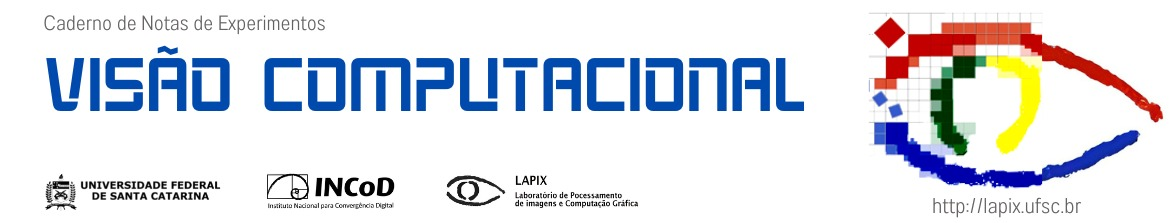

# 12.3.Classificação de Imagens com EfficientNet

No notebook anterior nós conhecemos a classificação de imagens com redes neurais convolucionais. Para tanto nós empregamos um notebook que utilizava o modelo de rede neural *ResNet - Residual Neural Network*. ResNets foram um modelo revolucionário de rede neural convolucional que introduziu o conceito do "bloco residual”, capaz de permitir que se projetasse redes neurais muito mais profundas do que até aquele momento, resolvendo de uma forma matematicamente muito elegante o problema dos “gradientes evanescentes”, que fazia com que em redes neurais muito profundas a propagação do erro durante o aprendizado se diluísse até o ponto em que fatores como erros de arredondamento e ruído acabavam anulando o efeito de aprendizado. Os blocos residuais tornaram desnecessários “acochambros” como os utilizados pela Google no modelo Inception para "injetar um sinal reforçado” pelo meio da rede neural. 

Apesar da sua excelente performance e dessas propriedades matemáticas e de elegância arquitetônica, que tornam as ResNets um modelo de didático por excelência, trata-se de um modelo publicado em dezembro de 2015. A luz da velocidade com que a tecnologia de aprendizado profundo evolui, isto torna esse modelo quase que "pré-histórico".

Neste notebook nós vamos retornar a tarefa de classificação de imagens, desta vez empregando o modelo de rede neural ***EfficientNet***. É um modelo muito mais moderno, publicado em maio de 2019, que propõe, além de várias estratégias para o tornar a rede neural mais compacta e eficiente, também uma sistemática para você escalar o modelo de rede neural de acordo com a complexidade do seu problema, permitindo a todo desenvolvedor criar modelos customizados sem grande esforço de pesquisa e sem muito risco de perda de qualidade dos resultados. Como são redes muito mais compactas, são indicadas para o desenvolvimento de aplicações embarcadas. O repositório de código dos autores vem com oito modelos prontos, numerados de b0 a b7, mas a estratégia proposta por eles permite facilmente você desenvolver modelos maiores ou menores.


# Autores:


* Aldo Von Wangenheim: aldo.vw@ufsc.br
* Thiago Zimmermann Loureiro Chaves: thiago.zlc@grad.ufsc.br
* Rodrigo de Paula e Silva Ribeiro: ribeiro.rodrigo@posgrad.ufsc.br


<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/12.3.Classifica%C3%A7%C3%A3o%20de%20Imagens%20EfficientNet.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

# Para utilizar a placa de vídeo no Google Colab...

1) clique no ▾ do lado de "Conectar"

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

5) Execute a célula abaixo. Ela deve retornar as informações da placa de vídeo.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!/opt/bin/nvidia-smi
!nvcc --version

Thu May 25 15:36:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

# Codigo para montar o Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Instalando as Bibliotecas Necessárias

---



In [ ]:
!pip install fastai torch torchvision
!pip install wandb -qU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from fastai.vision.all import *
from torchvision.models import *
from fastai.callback.wandb import *

import wandb

# Login WandB

Obs: Necessário pegar o código da API

Fica localizado no user-settings


---

In [ ]:
# Log in to your W&B account
!wandb login
import wandb

!wandb enabled

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
W&B enabled.




---


#Opcional: Para recarregar wandb

In [ ]:
!wandb login --relogin



---



# Opcional: Download Dataset Padrão

---



In [ ]:
!pip install gdown
!gdown 1xKxLCLAk9yQ-17SVfanJ35meDeRj2ivI
!unzip 'SplittedMendeley.zip'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0348 (8).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0040 (14).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/0- MIND0348 (1) branco2.jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/01-MIND0040 (7).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0040 (20).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0348 (7).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/0- MIND0348 (1) branco.jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/Spl

In [ ]:
# Set up data directory
path = Path("/content/content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset") #PATH DO DATASET
train_path = path/'train'
valid_path = path/'val'
test_path = path/'test'
size = 512
batch_size = 4

In [ ]:
data = ImageDataLoaders.from_folder(
    path, train='train', valid='val', test='test',
    item_tfms=Resize(size),
    batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)],
    bs=batch_size,
    num_workers=0
)

# Escolha seu modelo de EfficientNet
---

EfficientNet é uma arquitetura de rede neural convolucional que dimensiona uniformemente profundidade/largura/resolução usando um coeficiente composto. Ao contrário do que se faz convencionalmente (dimensionamento arbitrário destes fatores), o método de dimensionamento EfficientNet dimensiona uniformemente a largura, a profundidade e a resolução da rede com um conjunto de coeficientes fixos.


O método de dimensionamento composto é justificado pela intuição de que, se a imagem de entrada for maior, a rede precisa de mais camadas para aumentar o campo receptivo e mais canais para capturar padrões mais refinados na imagem maior. A "rede base" *EfficientNet-B0* é baseada nos blocos residuais de gargalo invertidos do MobileNetV2.

Neste contexto, os autores projetaram as EfficientNets, que alcançam precisão e eficiência muito melhores do que as ConvNets anteriores. Em particular, a EfficientNet-B7 atinge 84,3% de precisão top-1 de última geração no ImageNet, sendo **8,4x menor e 6,1x mais rápido** na inferência do que o melhor ConvNet existente.

As EfficientNets também transferem bem e alcançam precisão de última geração em CIFAR-100 (91,7%), Flowers (98,8%) e 3 outros conjuntos de dados de aprendizado de transferência, com uma ordem de magnitude a menos de parâmetros [1].

Modelos Disponíveis:


*   efficientnet_b0
*   efficientnet_b1
*   efficientnet_b2
*   efficientnet_b3
*   efficientnet_b4
*   efficientnet_b5
*   efficientnet_b6
*   efficientnet_b7

In [ ]:
from fastai.vision.models import efficientnet_b0
arch = efficientnet_b1(weights=True)
model = nn.Sequential(arch, nn.Linear(in_features=1000, out_features=data.c, bias=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:03<00:00, 74.1MB/s]


# Definindo Learner

---



In [ ]:
# Define learner
learn = Learner(
    dls=data,
    model=arch,
    metrics=[accuracy, top_k_accuracy],
    opt_func=Adam,
    loss_func=LabelSmoothingCrossEntropy(),
    cbs=[WandbCallback()]
)

#Iniciamos o projeto do Wandb

---

In [ ]:
# Train model
wandb.init(project="MindFungaApp2023", config={
    "learning_rate": 1e-3,
    "epochs": 15,
    "batch_size": batch_size
})

wandb: Currently logged in as: thiagozlc. Use `wandb login --relogin` to force relogin


Obs: Wandb pode causar uma reconexão da secção. Talvez tenha que esperar um pouco e executar a próxima de novo.

# Treinando o Modelo

---



## Treinamos utilizando a política de adaptação simultânea de taxa de aprendizado e momento linear da rede para superconvergência 1cycle

Abaixo um explicação retirada de nosso tutorial "How to resume an interrupted training session in fastai" disponível em: https://towardsdatascience.com/how-to-resume-an-interrupted-training-session-in-fastai-77c4f36cd3a1

O método fit_one_cycle() empregado pelo fast.ai funciona com taxas e momentos de aprendizado variados e adaptativos, seguindo uma curva em que a taxa é aumentada e depois diminuída, enquanto o momento é tratado de forma oposta, conforme mostrado na figura abaixo.

![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

Se você interromper um treino na epoch #10 de, digamos, 20 epochs e depois recomeçar por mais 9 epochs, você não terá o mesmo resultado de treinar ininterruptamente por 20 epochs, porque um novo treino do zero, mesmo que você carregue os pesos da última época, empregarão uma nova taxa de aprendizado e política de impulso e passarão pelo ciclo novamente.

O que você quer é começar de onde você foi interrompido no ciclo.

![imagem](https://miro.medium.com/max/720/0*AzuB9-kayY2Abfp3.png)

### O que é fit1cycle?

Fit1cycle é uma política de superconvergência desenvolvida por Leslie N. Smith. Está disponível como a política de treinamento preferida no fast.ai. Veja abaixo os detalhes:

* https://docs.fast.ai/callbacks.one_cycle.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

Se você quiser ver mais artigos, siga este link: Papers de Leslie N. Smith. Não entraremos em detalhes nesta postagem. Existem várias postagens no Medium apresentando e discutindo a política de treinamento fit1cycle de uma maneira fácil de ler:

* Training Neural Networks upto 10x Faster by Karanbir Chahal;
* SuperConvergence with inbuilt regularization by Yogesh Gurjar;
* Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates by Aditya Gupta;
* Fast.ai Part1 v2/v3 Notes — Learning Rates — from SGDR to 1cycle and Super-Convergence by Roger Mao;
* Reproducing Leslie N. Smith’s papers using fastai by Kushajveer Singh.

Esta última postagem de Kushajveer Singh tem um notebook Jupyter muito ilustrativo que vale a pena olhar. Há também um artigo muito interessante de Nachiket Tanksale chamado Finding Good Learning Rate e The One Cycle Policy, onde as taxas de aprendizado cíclico e o momento são discutidos.

Leia o nosso tutorial para saber mais sobre treino em etapas e 1cycle.

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.487012,2.840788,0.595898,0.778741,2:58:52
1,3.416472,4.846232,0.496823,0.724726,46:33
2,3.584479,5.348385,0.464471,0.673021,46:23
3,3.399767,6.101927,0.517331,0.739746,46:23
4,3.066022,6.409873,0.544772,0.744945,46:26


In [ ]:
# Evaluate model on validation set
interp = ClassificationInterpretation.from_learner(learn)

# Display best 5 and worst 5 results
interp.plot_top_losses(5, figsize=(20,20))
interp.plot_top_losses(5, largest=False, figsize=(20,20))

# Display heatmap of accuracy for each class
interp.plot_confusion_matrix(figsize=(12, 12), cmap='Blues')

#Salvando Modelo

---



In [ ]:
learn.save("PATH_QUE_DESEJA_SALVAR/NOME_DO_MODELO")

Path('/content/gdrive/Shareddrives/MindFunga/SplittedMendeleyV3/models/EfficientnetB4-MindFungaApp2023.pth')

#Formatação do Dataset


---



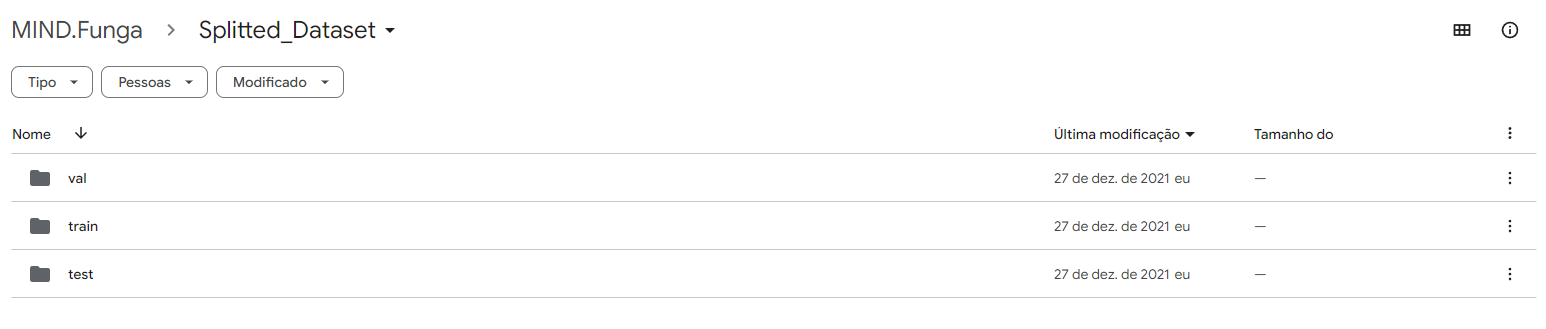

Os dados são separados por pastas, onde cada uma é uma classe

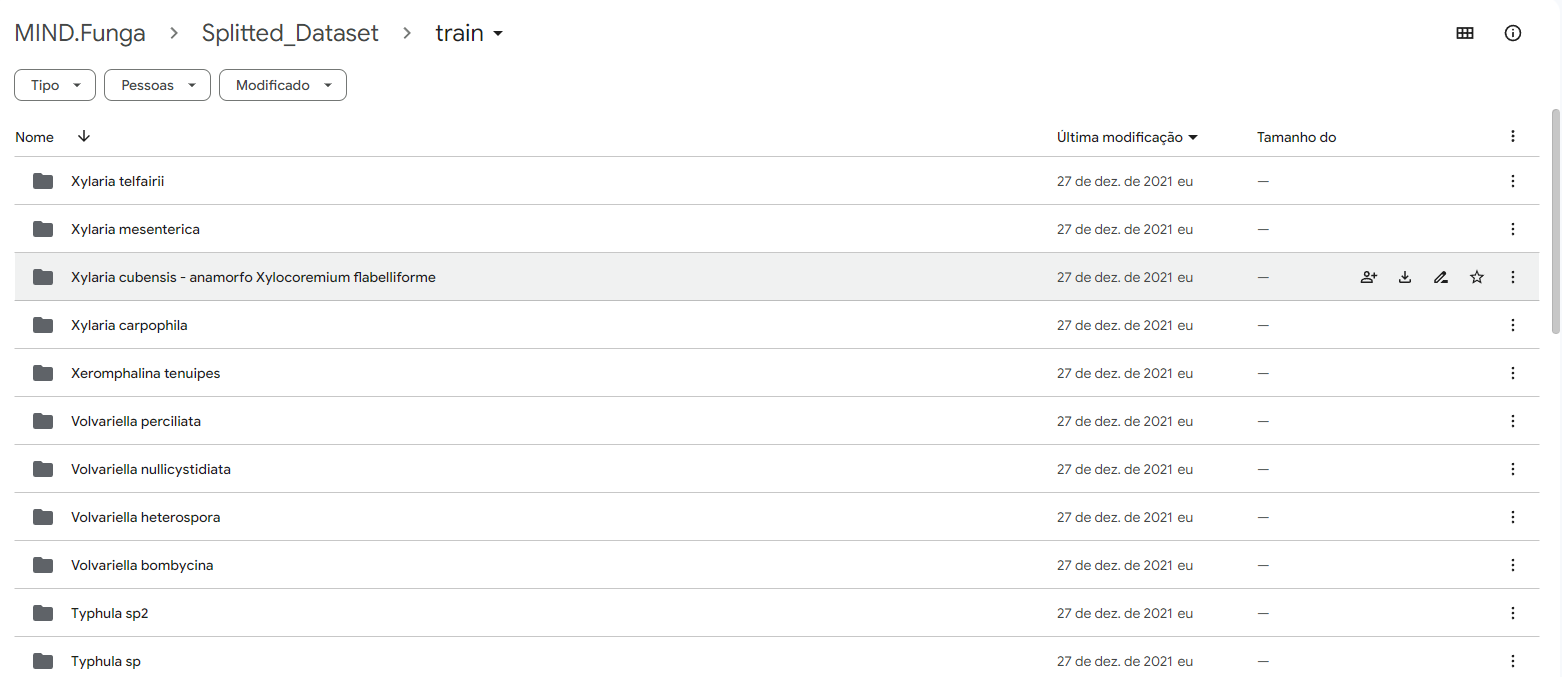